In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras


In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False
)
root.start()

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 1 day, 20:31:16
GitHash      = 0xbc49b62f5f43de3e5f9bfb039ee684580dd1a18c
XilinxDnaId  = 0x40020001013a928124b102c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv304 (Ubuntu 20.04.5 LTS)
BuildDate    = Thu 01 Sep 2022 06:11:09 PM PDT
Builder      = ddoering
###################################################


In [4]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
root.EpixHR.InitASIC([4,0,1,0,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic1

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
ERROR:pyrogue.Device.DigitalAsicStreamAxi.ePixHr10kT.EpixHR.PacketRegisters0:Entry ResetCounters not found
ERROR:pyrogue.Device.DigitalAsicStreamAxi.ePixHr10kT.EpixHR.PacketRegisters1:Entry ResetCounters not found
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/eP

In [35]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [36]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3F)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)

Locked lanes: fc0


In [37]:
def readPixelConfig(ASIC, x, y):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.get() #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def writedPixelConfig(ASIC, x, y, value):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.set(value) #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

In [38]:
#sets ASIC to point to the external DAC
ASIC.mTest.set(False)
print (f'Check trbit (0: medium gain, 1: high gain): %d' % ASIC.trbit.get())
#set pixel configuration
pixelList = [[100, 10, 0],[100, 20, 4],[100, 30, 8],[100, 40, 12]]
for i in range(len(pixelList)):
    print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    print (f'Writing individula pixel')
    writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pixelList[i][2])
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))

#code to check successive writes
#row = 111
#col = 180
#for pixelValue in (0, 8, 4, 12):
#    writedPixelConfig(ASIC, row, col, pixelValue)
#    print (f'Pixel setting %d (0: AR, 4: forced switch, 8: fixed low, 12: fixed high), readback: %d' % (pixelValue, readPixelConfig(ASIC, row, col)))


Check trbit (0: medium gain, 1: high gain): 1

Pixel [100, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0

Pixel [100, 20]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 4
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 4

Pixel [100, 30]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 8
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 8

Pixel [100, 40]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 12
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 12


In [39]:
# Remove previous dataset
#if os.path.isfile(f'{top_level}/test.dat'):
#    os.remove(f'{top_level}/test.dat')    
filename = '/u2/ddoering/ePixHR10kTLCLSIITiming_ASICV3_noise_320MHz_AHL_run1.dat'

In [40]:
if os.path.isfile(f'{filename}'):
    os.remove(f'{filename}')    
    
# Setup and open the file writer
writer = root.dataWriter._writer
writer.open(f'{filename}')

# Wait for the file write to open the file
while( writer.isOpen() is False):
    time.sleep(0.1)

# Wait a little bit for the file to open up
time.sleep(1.0)    
    
#sets TriggerRegisters
AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
print("Aquisition Counter " + str(AcqCount))
root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(20000) #in steps of 10ns
root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
#wait for the camera to get thermally stable
time.sleep(5.0)    
root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
initialFrameCounter = writer.getFrameCount()
# Wait for the file write noise data
while(writer.getFrameCount() < initialFrameCounter + 20000):
    print( f'Number of frames received: {writer.getFrameCount()}' )
    time.sleep(1)

# stops triggers
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

# Print the status
DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
#print( f'Delta Aquisition Counter: {DeltaAcqCount}')
print( f'Number of frames received: {writer.getFrameCount()}' )
        
# Close the file writer
writer.close()

# Wait for the file write to close the file
while( writer.isOpen() is True):
    time.sleep(0.1)

Aquisition Counter 5412396
Number of frames received: 25026
Number of frames received: 30032
Number of frames received: 35037
Number of frames received: 40043
Number of frames received: 45050


In [41]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
from numba import njit

def getData(localFile):

    file_header = [0]
    numberOfFrames = 0
    previousSize = 0
    while ((len(file_header)>0) and ((numberOfFrames<MAX_NUMBER_OF_FRAMES_PER_BATCH) or (MAX_NUMBER_OF_FRAMES_PER_BATCH==-1))):
        try:
            # reads file header [the number of bytes to read, EVIO]
            file_header = np.fromfile(localFile, dtype='uint32', count=2)
            payloadSize = int(file_header[0]/2)-2 #-1 is need because size info includes the second word from the header
            newPayload = np.fromfile(f, dtype='uint16', count=payloadSize) #(frame size splited by four to read 32 bit 
            #save only serial data frames
            if (numberOfFrames == 0):
                allFrames = [newPayload.copy()]
            else:
                newFrame  = [newPayload.copy()]
                allFrames = np.append(allFrames, newFrame, axis = 0)
            numberOfFrames = numberOfFrames + 1 
            #print ("Payload" , numberOfFrames, ":",  (newPayload[0:5]))
            previousSize = file_header
       
            if (numberOfFrames%1000==0):
                print("Read %d frames" % numberOfFrames)

        except Exception: 
            e = sys.exc_info()[0]
            #print ("Message\n", e)
            print ('\r', 'numberOfFrames read:', numberOfFrames, 'Size Error, currnt size', file_header, 'previous size', previousSize)
            

    return allFrames

def getDescImaData(localAllFrames):
##################################################
# image descrambling
##################################################
    numberOfFrames = localAllFrames.shape[0]
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
#numberOfFrames = allFrames.shape[0]
    print("numberOfFrames in the 3D array: " ,numberOfFrames)
    print("Starting descrambling images")
    currentRawData = []
    imgDesc = []
    if(numberOfFrames==1):
        [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData = [], newRawData = allFrames[0])
        imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
    else:
        for i in range(0, numberOfFrames):
        #get an specific frame
            [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData, newRawData = localAllFrames[i,:])
            currentRawData = rawImgFrame

        #get descrambled image from camera
            if (len(imgDesc)==0 and (readyForDisplay)):
                imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                currentRawData = []
            else:
                if readyForDisplay:
                    currentRawData = []
                    newImage = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                #newImage = currentCam.descrambleImage(rawImgFrame)
                #newImage = newImage.astype(np.float, copy=False)
                #if (np.sum(np.sum(newImage))==0):
                #    newImage[np.where(newImage==0)]=np.nan
                    imgDesc = np.concatenate((imgDesc, np.array([newImage[0]])),0)

    return imgDesc

In [42]:
f = open(filename, mode = 'rb')
imgDesc = []
for i in range(3):
    print("Starting to get data set %d" % (i))
    allFrames = getData(f)
    imgDesc2 = getDescImaData(allFrames)
    if i == 0:
        headers = allFrames[:,0:6]
        imgDesc = imgDesc2
    if i == 1: #skips the first dataset
        headers = allFrames[:,0:6]
        imgDesc = imgDesc2
    else:
        headers = np.concatenate((headers, allFrames[:,0:6]),0)
        imgDesc = np.concatenate((imgDesc, imgDesc2),0)
    if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
        break


numberOfFrames = allFrames.shape[0]


Starting to get data set 0
Read 1000 frames
Camera  ePixHr10kTBatcher  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
Camera  ePixHr10kTBatcher  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
Camera  ePixHr10kTBatcher  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images


0
(2000, 145, 384)
100 10
1
(2000, 145, 384)
100 20
2
(2000, 145, 384)
100 30
3
(2000, 145, 384)
100 40


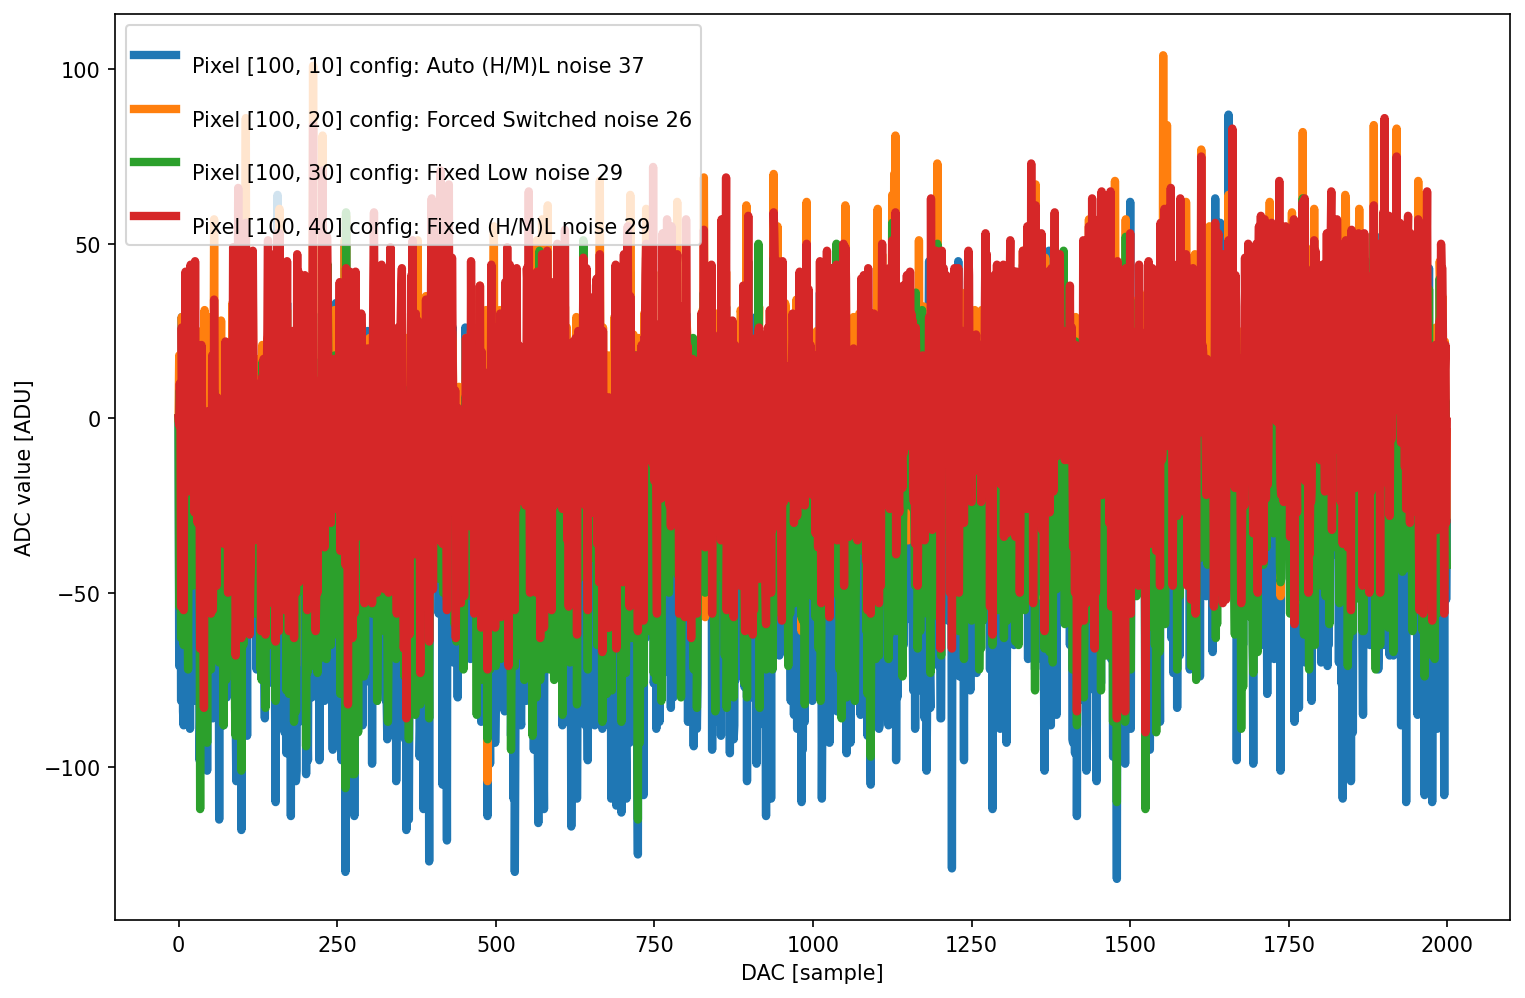

In [54]:
pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)L', 12)])
revd=dict([reversed(i) for i in pixelSettings.items()])
pixelSettings.update(revd)

plt.figure(1,figsize=(12,8),dpi=150)
for i in range(len(pixelList)):
    print(i)
    print(imgDesc.shape)
    print(pixelList[i][0],pixelList[i][1])
    dataset = imgDesc[:,pixelList[i][0],pixelList[i][1]] - float(np.mean(imgDesc[0:1000,pixelList[i][0],pixelList[i][1]]))
    plt.plot(dataset, linewidth=4, label=f'\nPixel [%d, %d] config: %s noise %d' %(pixelList[i][0], pixelList[i][1], pixelSettings[pixelList[i][2]], np.std(dataset)))
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.legend()
plt.show()

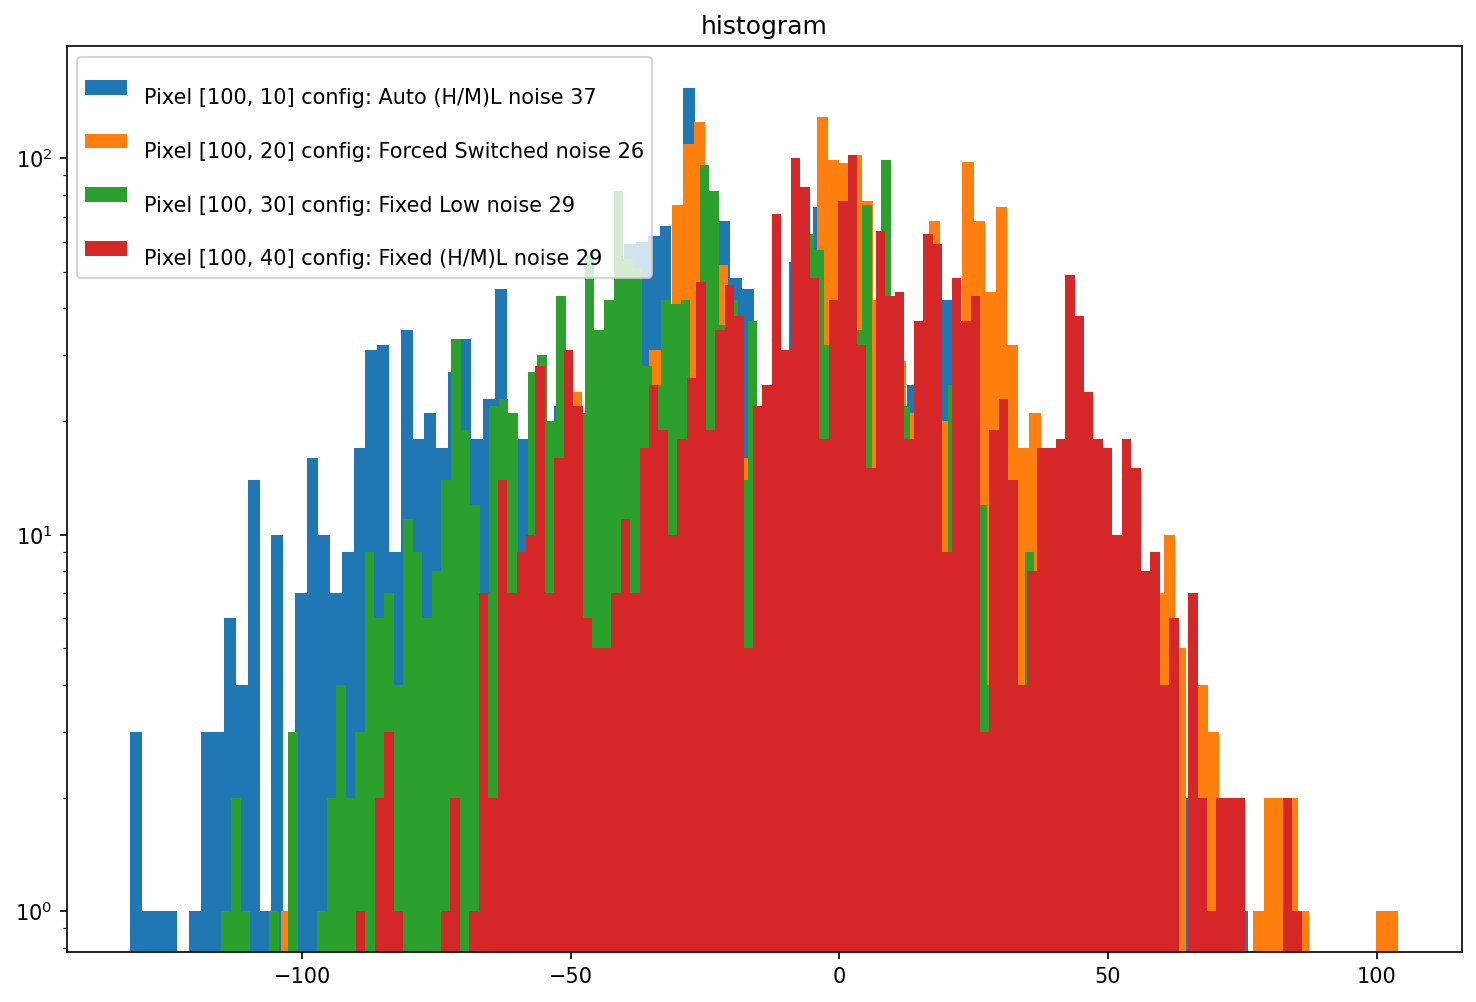

In [55]:
plt.figure(1,figsize=(12,8),dpi=150)
for i in range(len(pixelList)):
    dataset = (imgDesc[:,pixelList[i][0],pixelList[i][1]]) - float(np.mean(imgDesc[0:1000,pixelList[i][0],pixelList[i][1]]))
    plt.hist(dataset.reshape(-1), bins=100, label=f'\nPixel [%d, %d] config: %s noise %d' %(pixelList[i][0], pixelList[i][1], pixelSettings[pixelList[i][2]], np.std(dataset))) 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()